In [72]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import cv2
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gc
import pandas as pd
from tqdm import tqdm
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [73]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [74]:
#Get all classes 
main_data_dir = '/kaggle/input/hmdb-human-activity-recognition/HMDB_dataset/'
all_classes_names = os.listdir(main_data_dir)

In [75]:
image_height, image_width = 128, 128
max_images_per_train_class = 8000
max_images_per_test_class = 4000
 
classes_list = ["shoot_gun", "shoot_ball", "kiss", "smoke"]
 
model_output_size = len(classes_list)
num_classes = 51
frames_per_video = 200
batch_size = 16
epochs = 20

In [76]:
# Function to extract frames from a video
def extract_frames(video_path, skip=10):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    while True:
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255.0  # Normalize pixel values
        frames_list.append(normalized_frame)
    frames_list = [frame for i, frame in enumerate(frames_list) if i % skip == 0]
    video_reader.release()
    return np.array(frames_list)

def video_frame_generator(video_paths, labels, batch_size=16, every_nth_frame=10, max_frames=20, image_height=128, image_width=128):
    """
    Yields batches of frames and corresponding labels from video files.
    """
    while True:
        X, y = [], []
        for i in range(batch_size):
            video_idx = np.random.randint(0, len(video_paths))
            video_path = video_paths[video_idx]
            label = labels[video_idx]
            
            frames = extract_frames(video_path)
            print(frames.shape)
            # subsample:
            frames = frames[range(0, frames.shape[0], every_nth_frame),:,:,:]
            print(frames.shape)
            if frames is not None:
                # Initialize a padded array of zeros
                padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
                
                # Copy the frames into the padded array, truncating if necessary
                num_frames = min(len(frames), max_frames)
                padded_frames[:num_frames] = frames[:num_frames]
                
                X.append(padded_frames)
                y.append(label)  # Append label as-is or pad if needed for sequences
        
        # Convert to numpy arrays for use in model training
        X = np.array(X)
        y = np.array(y)

        yield X, y

In [77]:
def encoded_video_frame_generator(encoder, video_paths, labels, batch_size=16, max_frames=200, image_height=128, image_width=128):
    """
    Yields batches of frames and corresponding labels from video files.
    """
    while True:
        X, y = [], []
        for i in tqdm(range(batch_size)):
            video_idx = np.random.randint(0, len(video_paths))
            video_path = video_paths[video_idx]
            label = labels[video_idx]
            
            frames = extract_frames(video_path)
                
            if frames is not None:
                # Initialize a padded array of zeros
                padded_frames = np.zeros((max_frames, image_height, image_width, 3), dtype=np.float32)
                
                # Copy the frames into the padded array, truncating if necessary
                num_frames = min(len(frames), max_frames)
                padded_frames[:num_frames] = frames[:num_frames]
                encoded_frames = [encoder(np.expand_dims(frame, axis=0)) for frame in padded_frames]
                X.append(np.squeeze(encoded_frames, axis=1))
                y.append(label)  # Append label as-is or pad if needed for sequences
        
        # Convert to numpy arrays for use in model training
        X = np.array(X)
        y = np.array(y)

        yield X, y

In [78]:
# Prepare paths and labels for training and testing
video_paths_train = [os.path.join(main_data_dir, cls, f) 
                     for cls in all_classes_names 
                     for f in os.listdir(os.path.join(main_data_dir, cls)) 
                     if "training" in f]

labels_train = [all_classes_names.index(cls) 
                for cls in all_classes_names 
                for f in os.listdir(os.path.join(main_data_dir, cls)) 
                if "training" in f]

video_paths_test = [os.path.join(main_data_dir, cls, f) 
                    for cls in all_classes_names 
                    for f in os.listdir(os.path.join(main_data_dir, cls)) 
                    if "testing" in f]

labels_test = [all_classes_names.index(cls) 
               for cls in all_classes_names 
               for f in os.listdir(os.path.join(main_data_dir, cls)) 
               if "testing" in f]

print(f"Total Training Videos: {len(video_paths_train)}, Total Test Videos: {len(video_paths_test)}")

Total Training Videos: 5215, Total Test Videos: 1551


In [79]:
# Data Generators 
# Create train and test generators
train_gen = video_frame_generator(video_paths_train, labels_train, batch_size, frames_per_video, image_height, image_width)
test_gen = video_frame_generator(video_paths_test, labels_test, batch_size, frames_per_video, image_height, image_width)

In [80]:
#pretrained_image_classifier = keras.models.load_model("/kaggle/input/img_enc.h5/keras/default/1/img_enc.h5")

#img_enc = keras.Sequential([
#    layers.Input(shape=(128, 128, 3)),  # Ensure input shape matches your image size
#    *pretrained_image_classifier.layers[:-1]  # Exclude the final output layer
#])
#img_enc.summary()

In [81]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load pretrained VGG-16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Select an intermediate layer for feature extraction
layer_name = 'block5_pool'  # Last pooling layer (output shape: (None, 4, 4, 512))
img_enc = Model(inputs=vgg16.input, outputs=vgg16.get_layer(layer_name).output)

# Summary of the new model
img_enc.summary()

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# encoded generators
train_batch_size = 2000
frames_per_video = 20
test_batch_size = 200
train_enc_gen = encoded_video_frame_generator(img_enc, video_paths_train, labels_train, train_batch_size, frames_per_video, image_height, image_width)
test_enc_gen = encoded_video_frame_generator(img_enc, video_paths_test, labels_test, test_batch_size, frames_per_video, image_height, image_width)

In [83]:
X_train, y_train = next(train_enc_gen)
X_train.shape

100%|██████████| 2000/2000 [12:27<00:00,  2.68it/s]


(2000, 20, 4, 4, 512)

In [84]:
ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(y_train.shape[0]).batch(50)
train_ds, val_ds = tf.keras.utils.split_dataset(ds, left_size=0.8, right_size=0.2, shuffle=True)

In [85]:
X_test, y_test = next(test_enc_gen)

100%|██████████| 200/200 [01:15<00:00,  2.65it/s]


In [86]:
img_enc_lstm = keras.Sequential([
    layers.LSTM(128, return_sequences=False),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")  
])

# *Explicitly Build the Model by Passing Sample Input*
# Generate a sample input with the correct shape
img_enc_lstm(np.expand_dims(X_train[0], axis=0))

print(img_enc_lstm.summary())
# compile
img_enc_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train
train_hist = img_enc_lstm.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)]
)

ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=5. Full shape received: (1, 20, 4, 4, 512)

In [ ]:
history_frame = pd.DataFrame(train_hist.history)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(history_frame.index, history_frame['accuracy'], label='train')
ax[0].plot(history_frame.index, history_frame['val_accuracy'], label='val')
_ = ax[0].set_xlabel('Epoch')
_ = ax[0].set_ylabel('Accuracy')
_ = ax[0].legend(loc='lower right')
_ = ax[0].set_title("Accuracy Curve")

ax[1].plot(history_frame.index, history_frame['loss'], label='train')
ax[1].plot(history_frame.index, history_frame['val_loss'], label='val')
_ = ax[1].set_xlabel('Epoch')
_ = ax[1].set_ylabel('Loss')
_ = ax[1].legend(loc='upper right')
_ = ax[1].set_title("Loss Curve")

In [ ]:
# Evaluate the model
evaluation = img_enc_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

# ConvLSTM2D model 

In [87]:
conv_lstm_model = keras.Sequential([
    layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                      input_shape=(frames_per_video, 4, 4, 512),  # Match the current img_enc output
                      padding='same', 
                      return_sequences=False,  # Only return final output
                      activation='relu'),
    layers.BatchNormalization(),  # Normalize for stable training
    layers.Flatten(),  # Flatten for dense layers
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),  # Dropout to prevent overfitting
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),  # Dropout to prevent overfitting
    layers.Dense(num_classes, activation="softmax")  # Final classification layer
])

# Test the model with a sample input
X_sample = np.random.rand(1, frames_per_video, 4, 4, 512)  # Sample input shape matching img_enc output
conv_lstm_model(X_sample)  # Run a sample input to build the model
print(conv_lstm_model.summary())  # Print model summary

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_11 (ConvLSTM2D)     │ (None, 4, 4, 64)       │     1,327,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 51)             │         6,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,481,907 (5.65 MB)

 Trainable params: 1,481,779 (5.65 MB)

 Non-trainable params: 128 (512.00 B)

None


In [88]:
conv_lstm_model.compile(optimizer='adam', 
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy'])


In [103]:
train_hist = conv_lstm_model.fit(
    train_ds,  # Training dataset
    epochs=100,  # Number of epochs
    validation_data=val_ds,  # Validation dataset
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
    ]
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.0210 - loss: 12.0525 - val_accuracy: 0.0225 - val_loss: 11.1859 - learning_rate: 1.0000e-04
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.0275 - loss: 11.2147 - val_accuracy: 0.0250 - val_loss: 10.8692 - learning_rate: 1.0000e-04
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.0287 - loss: 10.8404 - val_accuracy: 0.0350 - val_loss: 10.5593 - learning_rate: 1.0000e-04
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.0292 - loss: 10.5123 - val_accuracy: 0.0275 - val_loss: 10.2683 - learning_rate: 1.0000e-04
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.0364 - loss: 10.1952 - val_accuracy: 0.0750 - val_loss: 9.9618 - learning_rate: 1.0000e-04
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.0407 - loss: 9.9475 - val_accuracy: 0.0675 - val_loss: 9.7497 - learning_rate: 1.0000e-04
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/

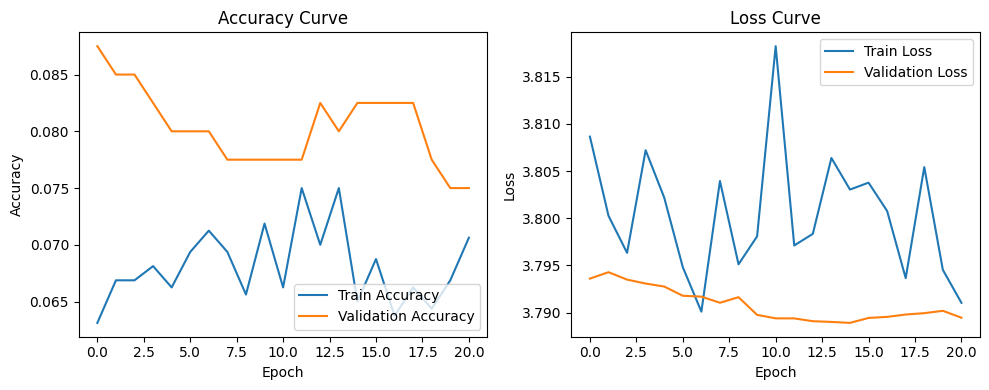

In [97]:
# Convert training history to a DataFrame
history_frame = pd.DataFrame(train_hist.history)

# Plot Accuracy and Loss
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy Curve
ax[0].plot(history_frame.index, history_frame['accuracy'], label='Train Accuracy')
ax[0].plot(history_frame.index, history_frame['val_accuracy'], label='Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_title('Accuracy Curve')

# Loss Curve
ax[1].plot(history_frame.index, history_frame['loss'], label='Train Loss')
ax[1].plot(history_frame.index, history_frame['val_loss'], label='Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='upper right')
ax[1].set_title('Loss Curve')

plt.tight_layout()
plt.show()

In [102]:
### model not better :(
from tensorflow.keras.regularizers import l2
conv_lstm_model = keras.Sequential([
    # ConvLSTM2D Layer 1
    layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), 
                      input_shape=(frames_per_video, 4, 4, 512), 
                      padding='same', 
                      return_sequences=True,  # Return sequences for deeper processing
                      activation='relu',
                      kernel_regularizer=l2(0.01)),  # L2 regularization
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # ConvLSTM2D Layer 2
    layers.ConvLSTM2D(filters=64, kernel_size=(3, 3),
                      padding='same',
                      return_sequences=False,  # Final output
                      activation='relu',
                      kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Flatten for Dense Layers
    layers.Flatten(),

    # Dense Layer 1
    layers.Dense(128, activation="relu", kernel_regularizer=l2(0.01)),
    layers.Dropout(0.4),

    # Dense Layer 2
    layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
    layers.Dropout(0.4),

    # Output Layer
    layers.Dense(num_classes, activation="softmax")
])

conv_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),  # Reduced learning rate for stability
    loss="sparse_categorical_crossentropy",  # Use sparse cross-entropy for integer labels
    metrics=["accuracy"]
)

conv_lstm_model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_12 (ConvLSTM2D)     │ (None, 20, 4, 4, 64)   │     1,327,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 20, 4, 4, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 20, 4, 4, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_13 (ConvLSTM2D)     │ (None, 4, 4, 64)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 51)             │         3,315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,765,811 (6.74 MB)

 Trainable params: 1,765,555 (6.74 MB)

 Non-trainable params: 256 (1.00 KB)